<h1>Мат. пакеты, лаб. работа №2, 9383, Гордон Дмитрий<h1>

<h2>1. Загрузка .wav файла<h2>

In [3]:
import math
import numpy as np
import wave
import sys
from scipy import signal
from matplotlib import pyplot as plt
from scipy.io.wavfile import write

#functions

def printGraphics(data, title):
    plt.figure(figsize=(20, 8), dpi=360)
    plt.title(title)
    plt.plot(data)
    plt.show()

def DPF(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        X[k] = sum(x[n] * np.exp((-2*np.pi*1j * k * n) / N) for n in range(N))
    return X

def F0(interval, n_l):
    max_indices = np.argmax(interval)
    max = interval[max_indices]
    avg = np.average(interval)
    if max >= avg * 2:
        return n_l + max_indices
    else:
        return 0

def Fi(interval, n_l, prev_value):
    max_indices = np.argmax(interval)
    max = interval[max_indices]
    avg = np.average(interval)
    if max >= avg * 2 and max < prev_value:
        return n_l + max_indices
    else:
        return 0

def F(magnitudes, indices, number):
    f = []
    for i, interval in enumerate(magnitudes):
        index = indices[i]
        if index != 0:
            l = index * (number + 1) - (n_u - n_l) // 2
            u = l + (n_u - n_l) * 2
            f1_index = Fi(interval[l:u + 1], l, interval[index])
            f += [S_r * f1_index for j in range(len(interval))]
        else:
            f += [0 for j in range(len(interval))]
    return f
# Extract Raw Audio from Wav File
spf = wave.open("pushkin.wav", "r")
f_i = spf.readframes(-1)
f_i = np.frombuffer(f_i, "int16")
sample_rate = spf.getframerate()

<h2>2. Построение F0, F1, F2 и F3<h2>

Пусть частота дискретизации сигнала $F_d$ Hz.
<br>Выберем $N$ - размерность ДПФ (для использования быстрого алгоритма FFT $N = 2^n$ - степень двойки). Я выбрал $N = 2048$. Для перевода частоты $f_i$ в отсчёт амплитудного спектра $n_i$ используем формулу:
$$n_i = \left[\frac{f_i}{S_r}\right] \text{, где }S_r = \frac{F_d}{N} \text{ - текущее спектральное разрешение.}$$
<br>Например, для $F_d = 16000$ Hz и $N = 2048$ получаем $S_r \approx 7.8$ Hz. То есть один отсчёт отвечает примерно за 8 Hz.
<br> Пусть диапозон основного тона для нашего голоса $[80, 200]$, в отсчётах спектра - $\left[\frac{80}{S_r}, \frac{200}{S_r}\right]$ = $[10, 25]$.
$$\text{Алгоритм построениия $F_i$}$$
<br> 1. Разбиваем сигнал на отрезки длиной $N$. Рекомендуется работа с перекрытиями. У меня каждый кадр перескается с другим в $0.5N$ точках.
<br> 2. На каждом отрезке сигнал предварительно умножаем на окно - я умножал на окно Хемминга np.hamming, - затем вычисляется ДПФ - я использовал np.fft.fft - и на его основе вычисляется амплитудный спектр в интервале $(0, N/2)$
<br> 3. Ищем существенное максимальное значение амплитудного спектра на отрезке $\left[n_l, n_u\right] = \left[10, 25\right]$ - это будет частота основного тона $F0$ (точка амплитудного спектра $n_0$). Если такого максимума нет - это интервал паузы или не вокализованного звука. Полагаем $F0 = 0$.
<br>4. В окрестности точки $2n_0$, $3n_0$ и т.д. ищем $F1, F2$ и т.д.
<br> На рис. 1 - 4 приведены графики F0, F1, F2

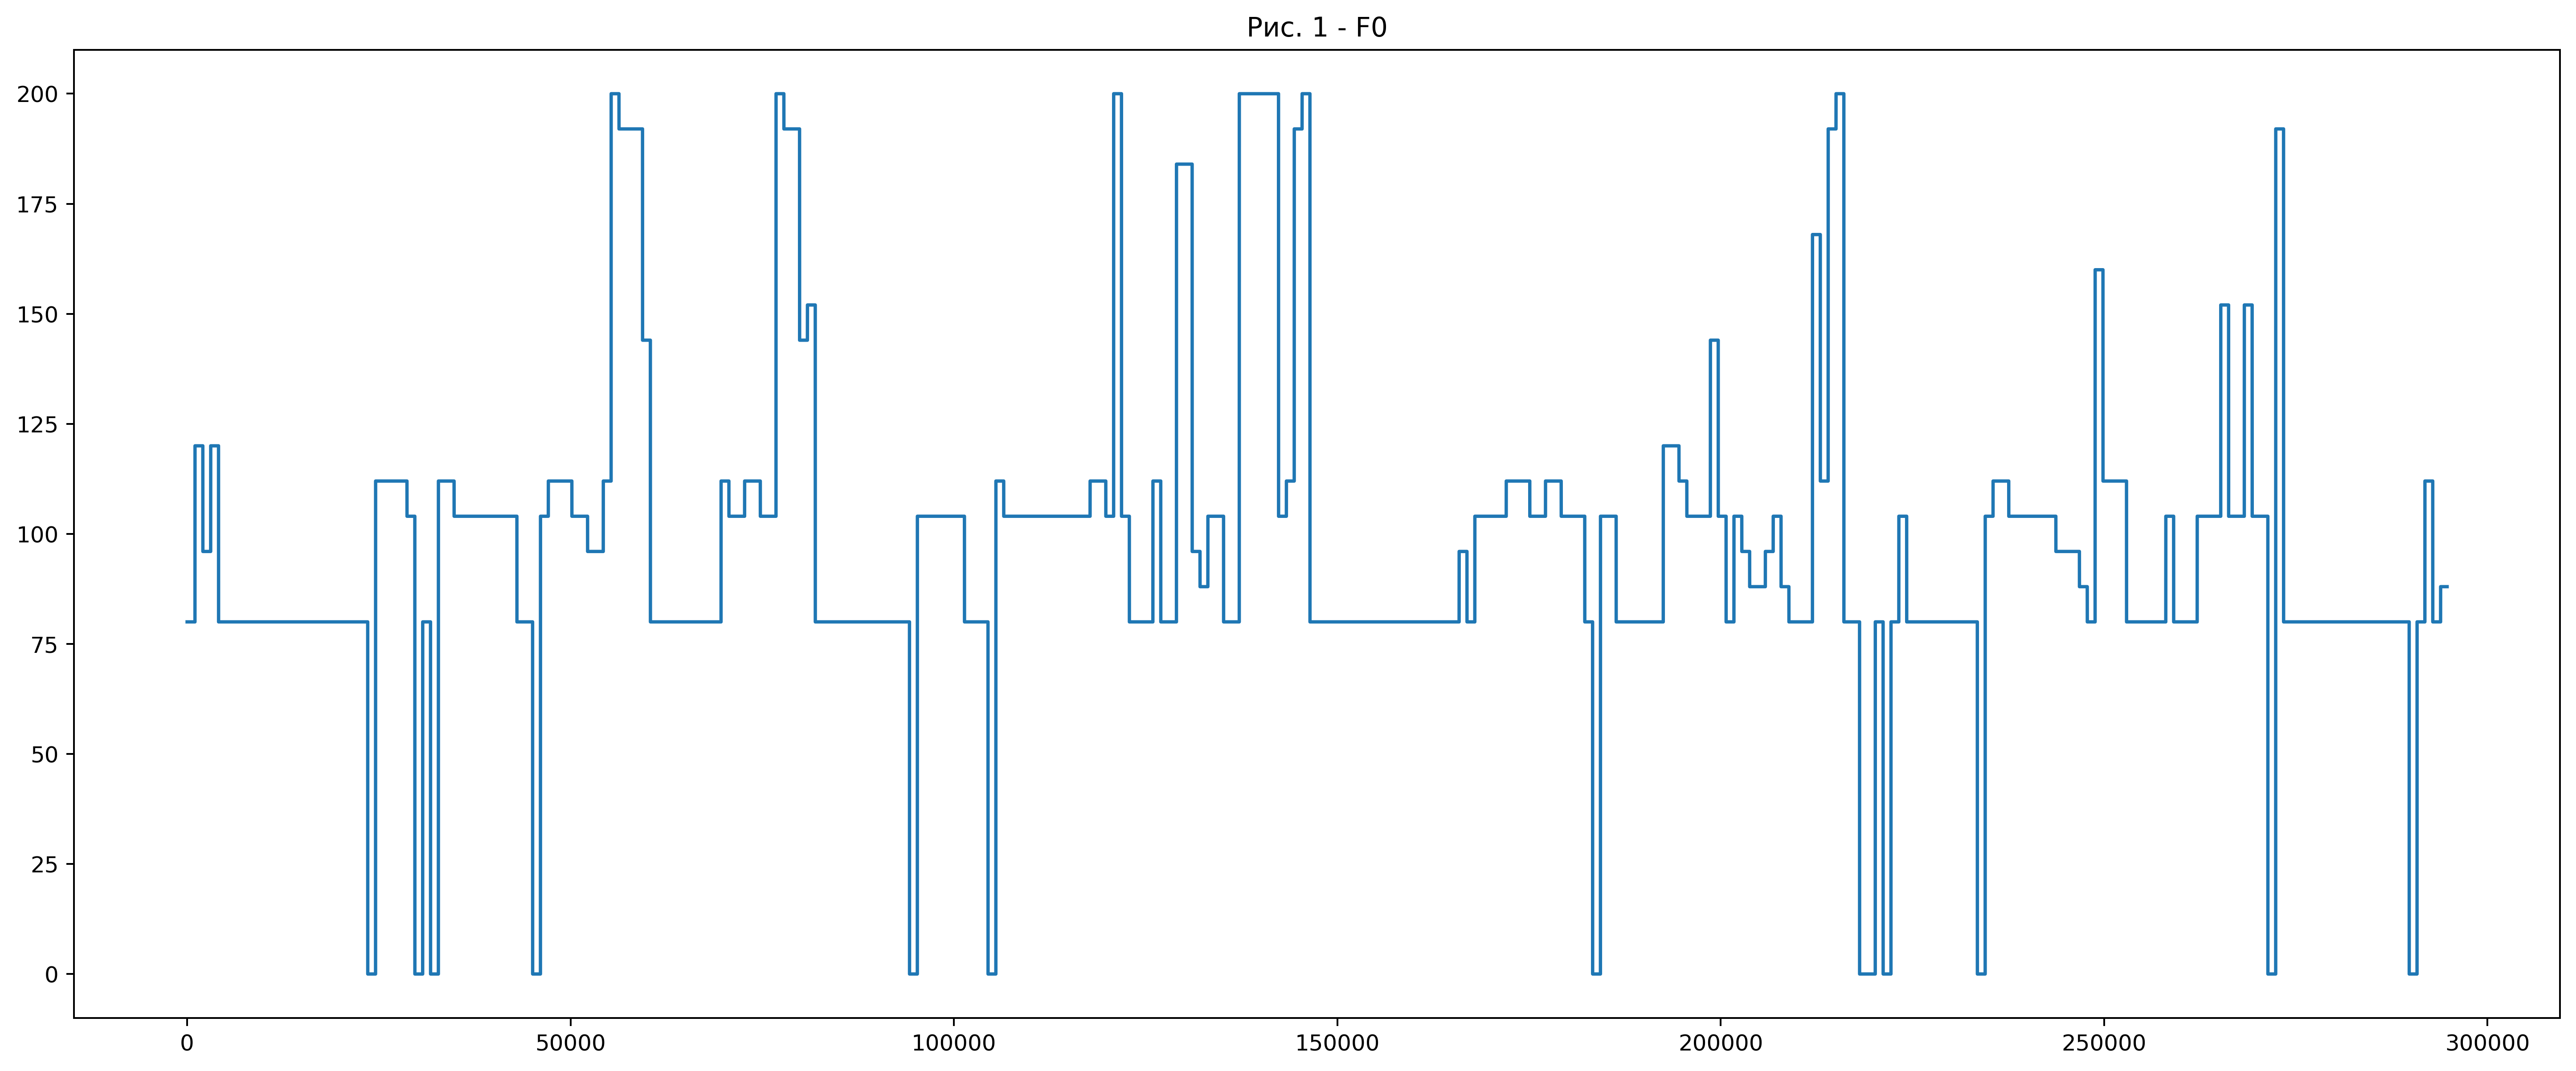

In [4]:
N = 2048
S_r = round(sample_rate/N)
f_l = 80
f_u = 200
n_l = f_l // S_r
n_u = f_u // S_r

#intervals
step = int(N/2) #overleap size
intervals = np.array([f_i[i : i + N] for i in range(0, len(f_i) - N + step, step)], dtype=object)

#multiply by hamming window
intervals = np.array([interval * np.hamming(len(interval)) for interval in intervals], dtype=object)

#FFT
#intervals = np.array([DPF(interval) for interval in intervals], dtype=object) - too long
intervals = np.array([np.fft.fft(interval) for interval in intervals], dtype=object)

#magnitude
magnitudes = np.array([])
magnitudes = np.array([np.absolute(interval[:len(interval)//2]) for interval in intervals], dtype=object)

#magnitude maxes
f0 = []
indices = []
for interval in magnitudes:
    index = F0(interval[n_l:n_u + 1], n_l)
    indices.append(index)
    f0 += [S_r * index for i in range(len(interval))]
printGraphics(f0, 'Рис. 1 - F0')

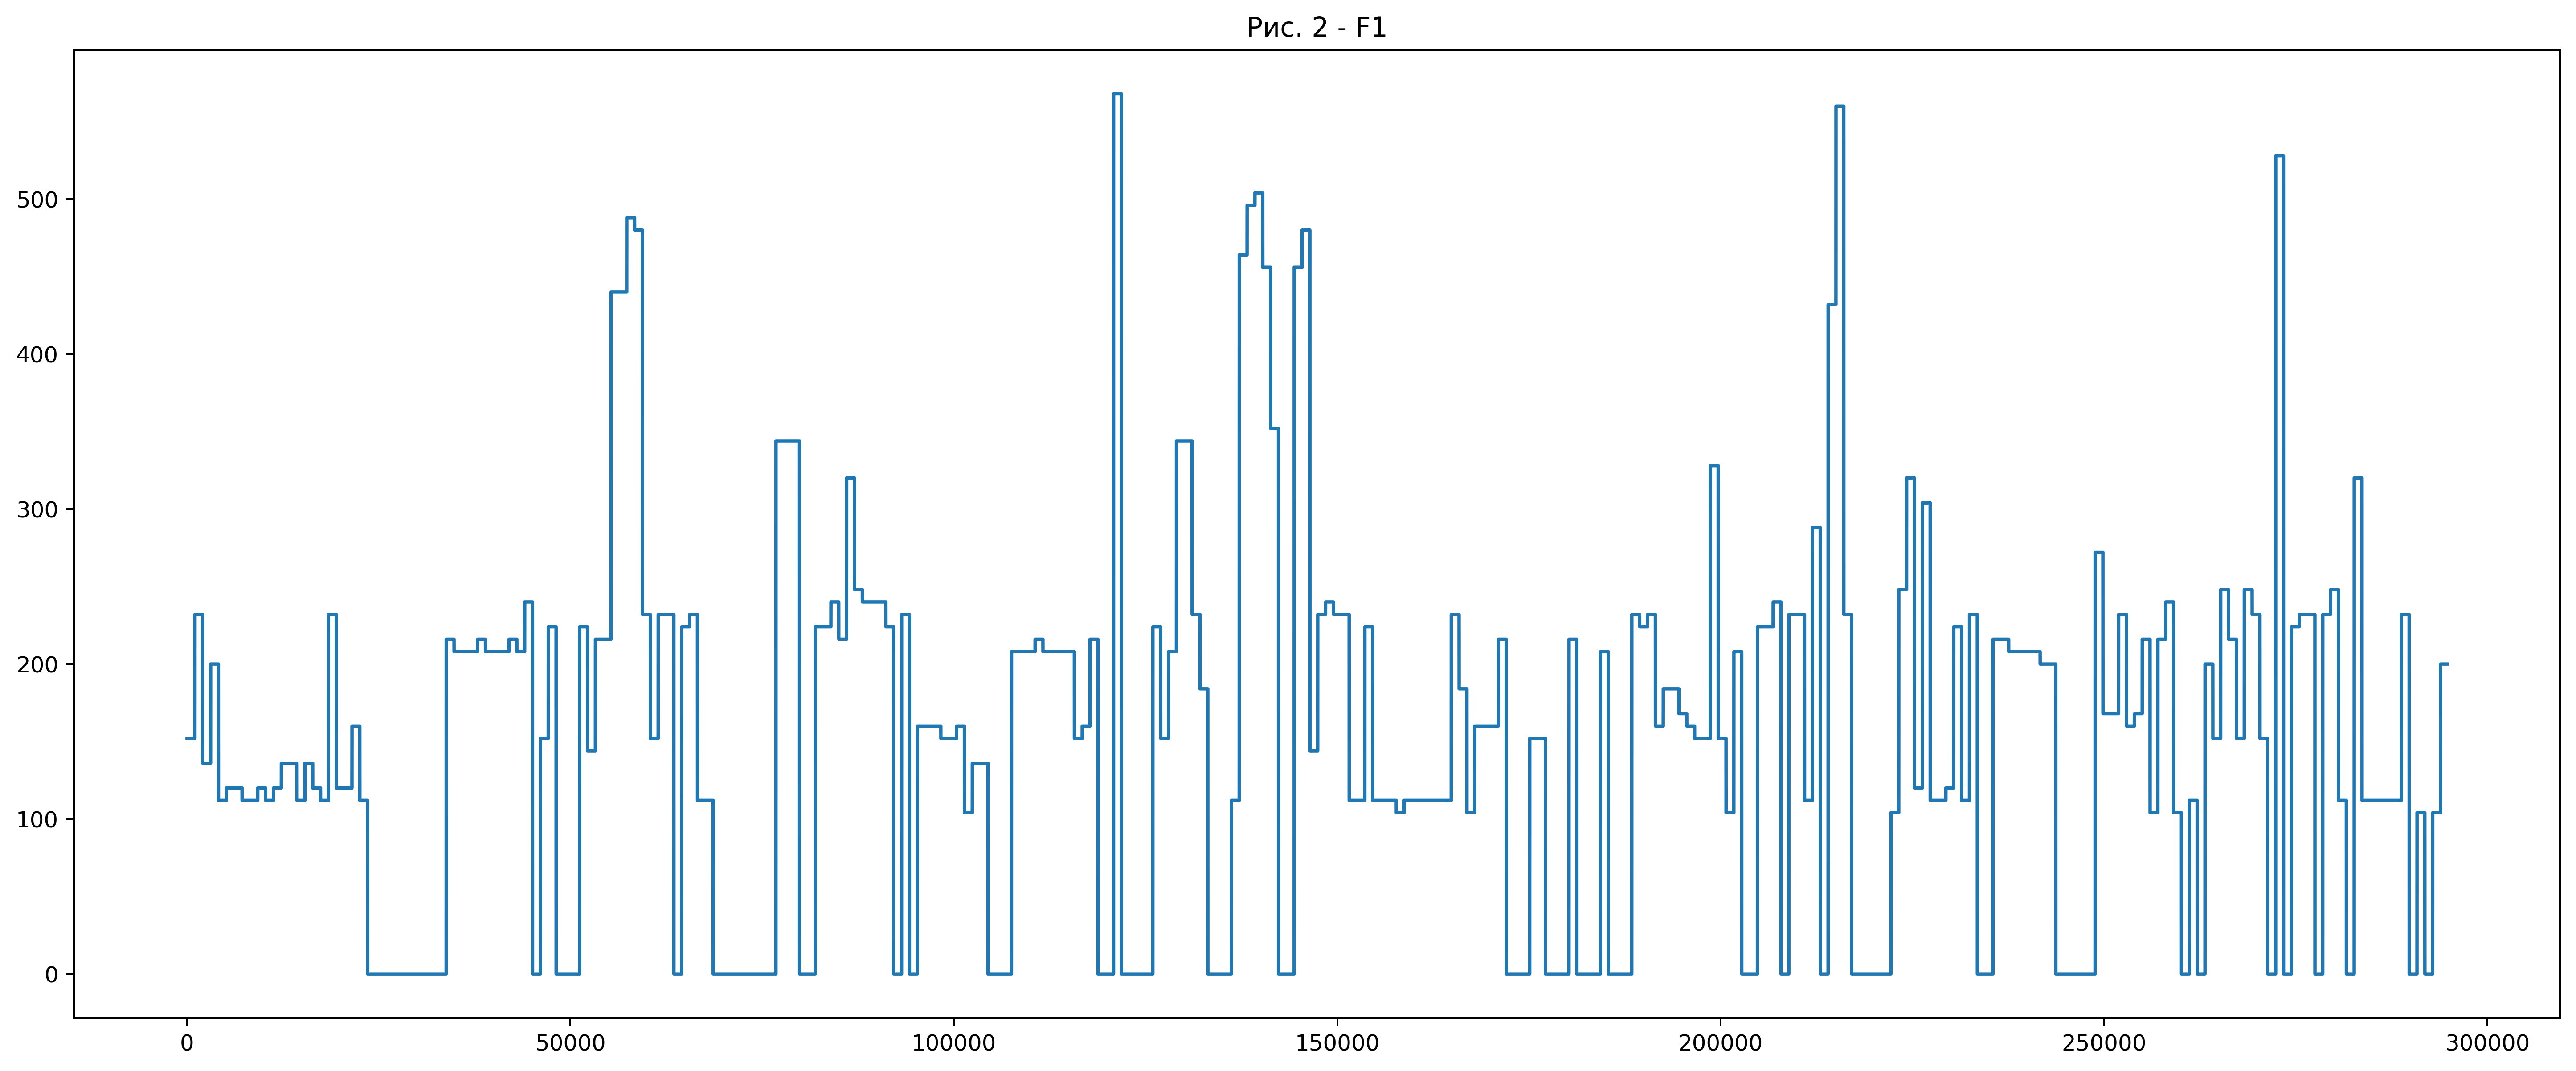

In [5]:
f1 = F(magnitudes, indices, 1)
printGraphics(f1, 'Рис. 2 - F1')

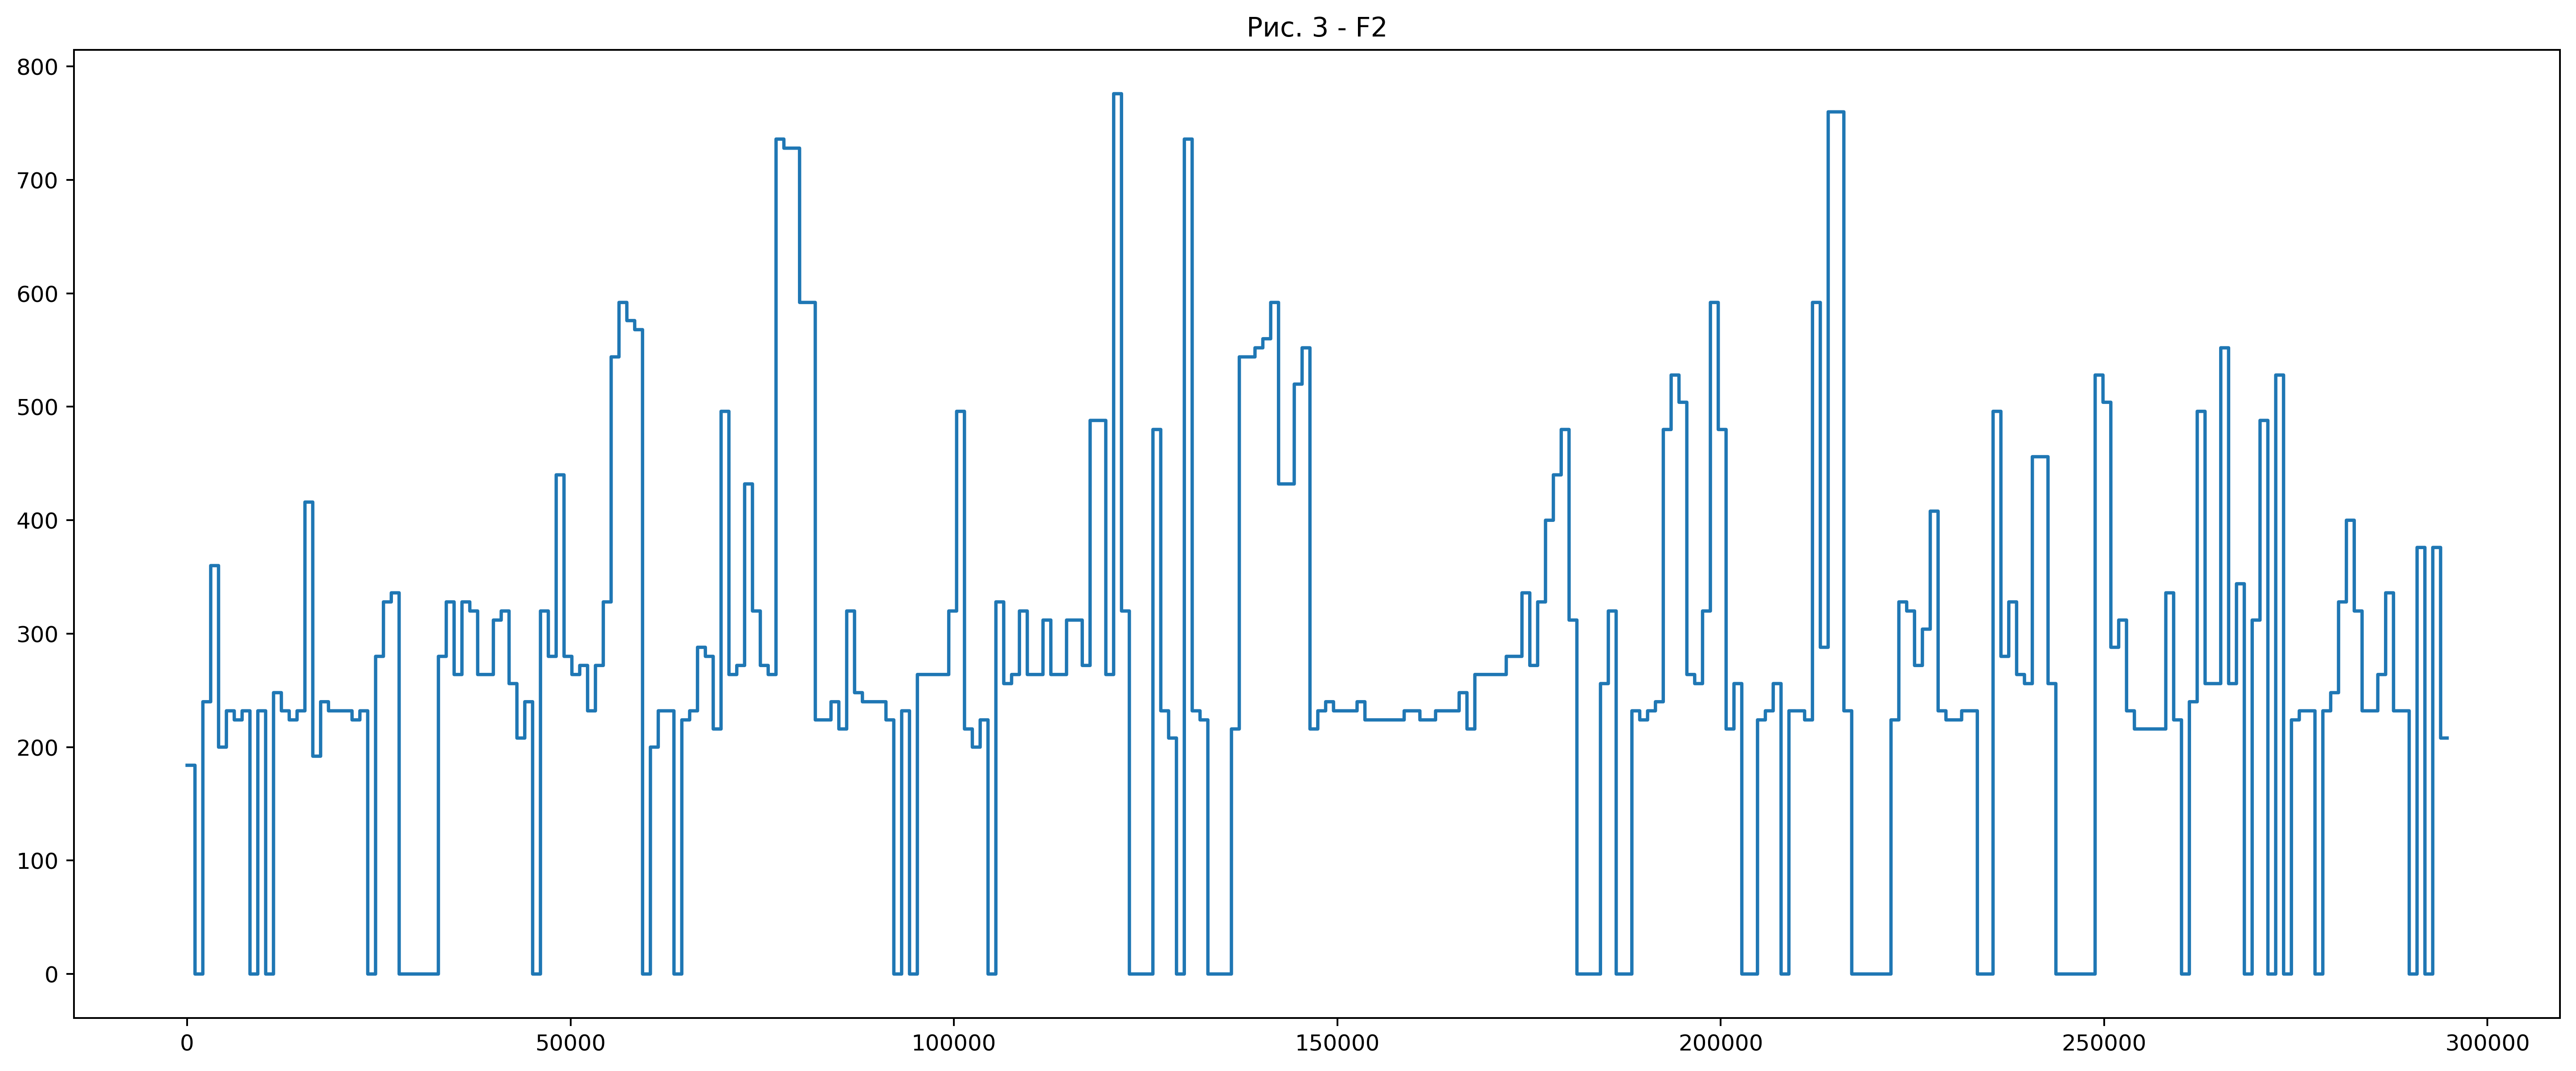

In [6]:
f2 = F(magnitudes, indices, 2)
printGraphics(f2, 'Рис. 3 - F2')

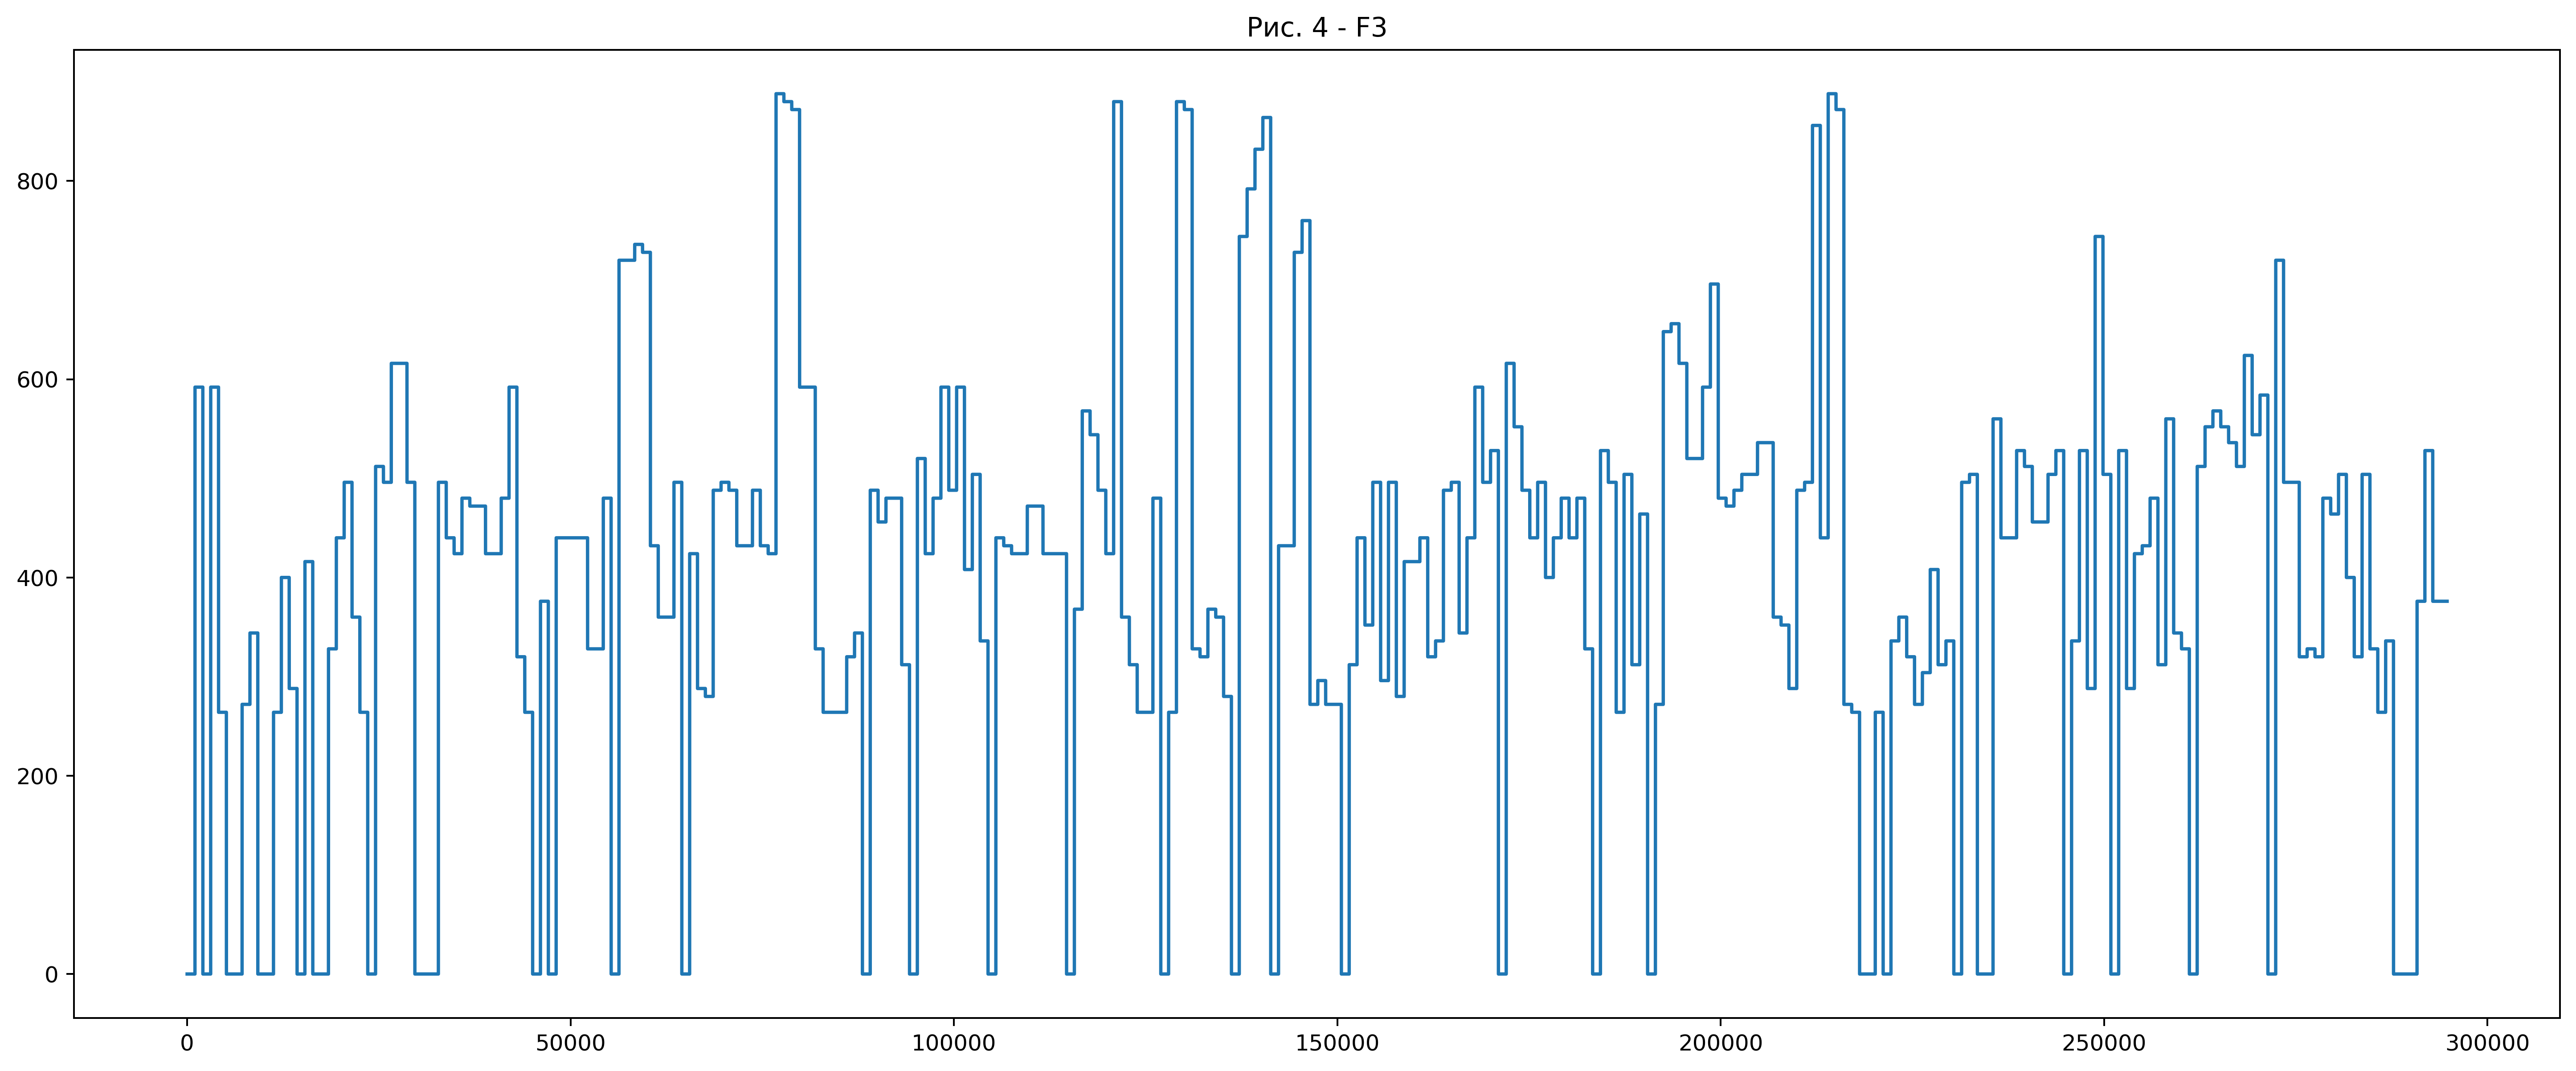

In [7]:
f3 = F(magnitudes, indices, 3)
printGraphics(f3, 'Рис. 4 - F3')

<h2>3. Сонограма<h2>

Сонограма - это изображение кратковременного спектра сигнала (спектров на последовательности кадров) в координатах времени (горизонтальная ось), частоты (вертикальная ось) и энергии голоса (цвет).
<br> Интенсивность цвета отображает амплитуду спектра. 
<br> Для построения сонограмы была использована функция specgram из matplotlib.

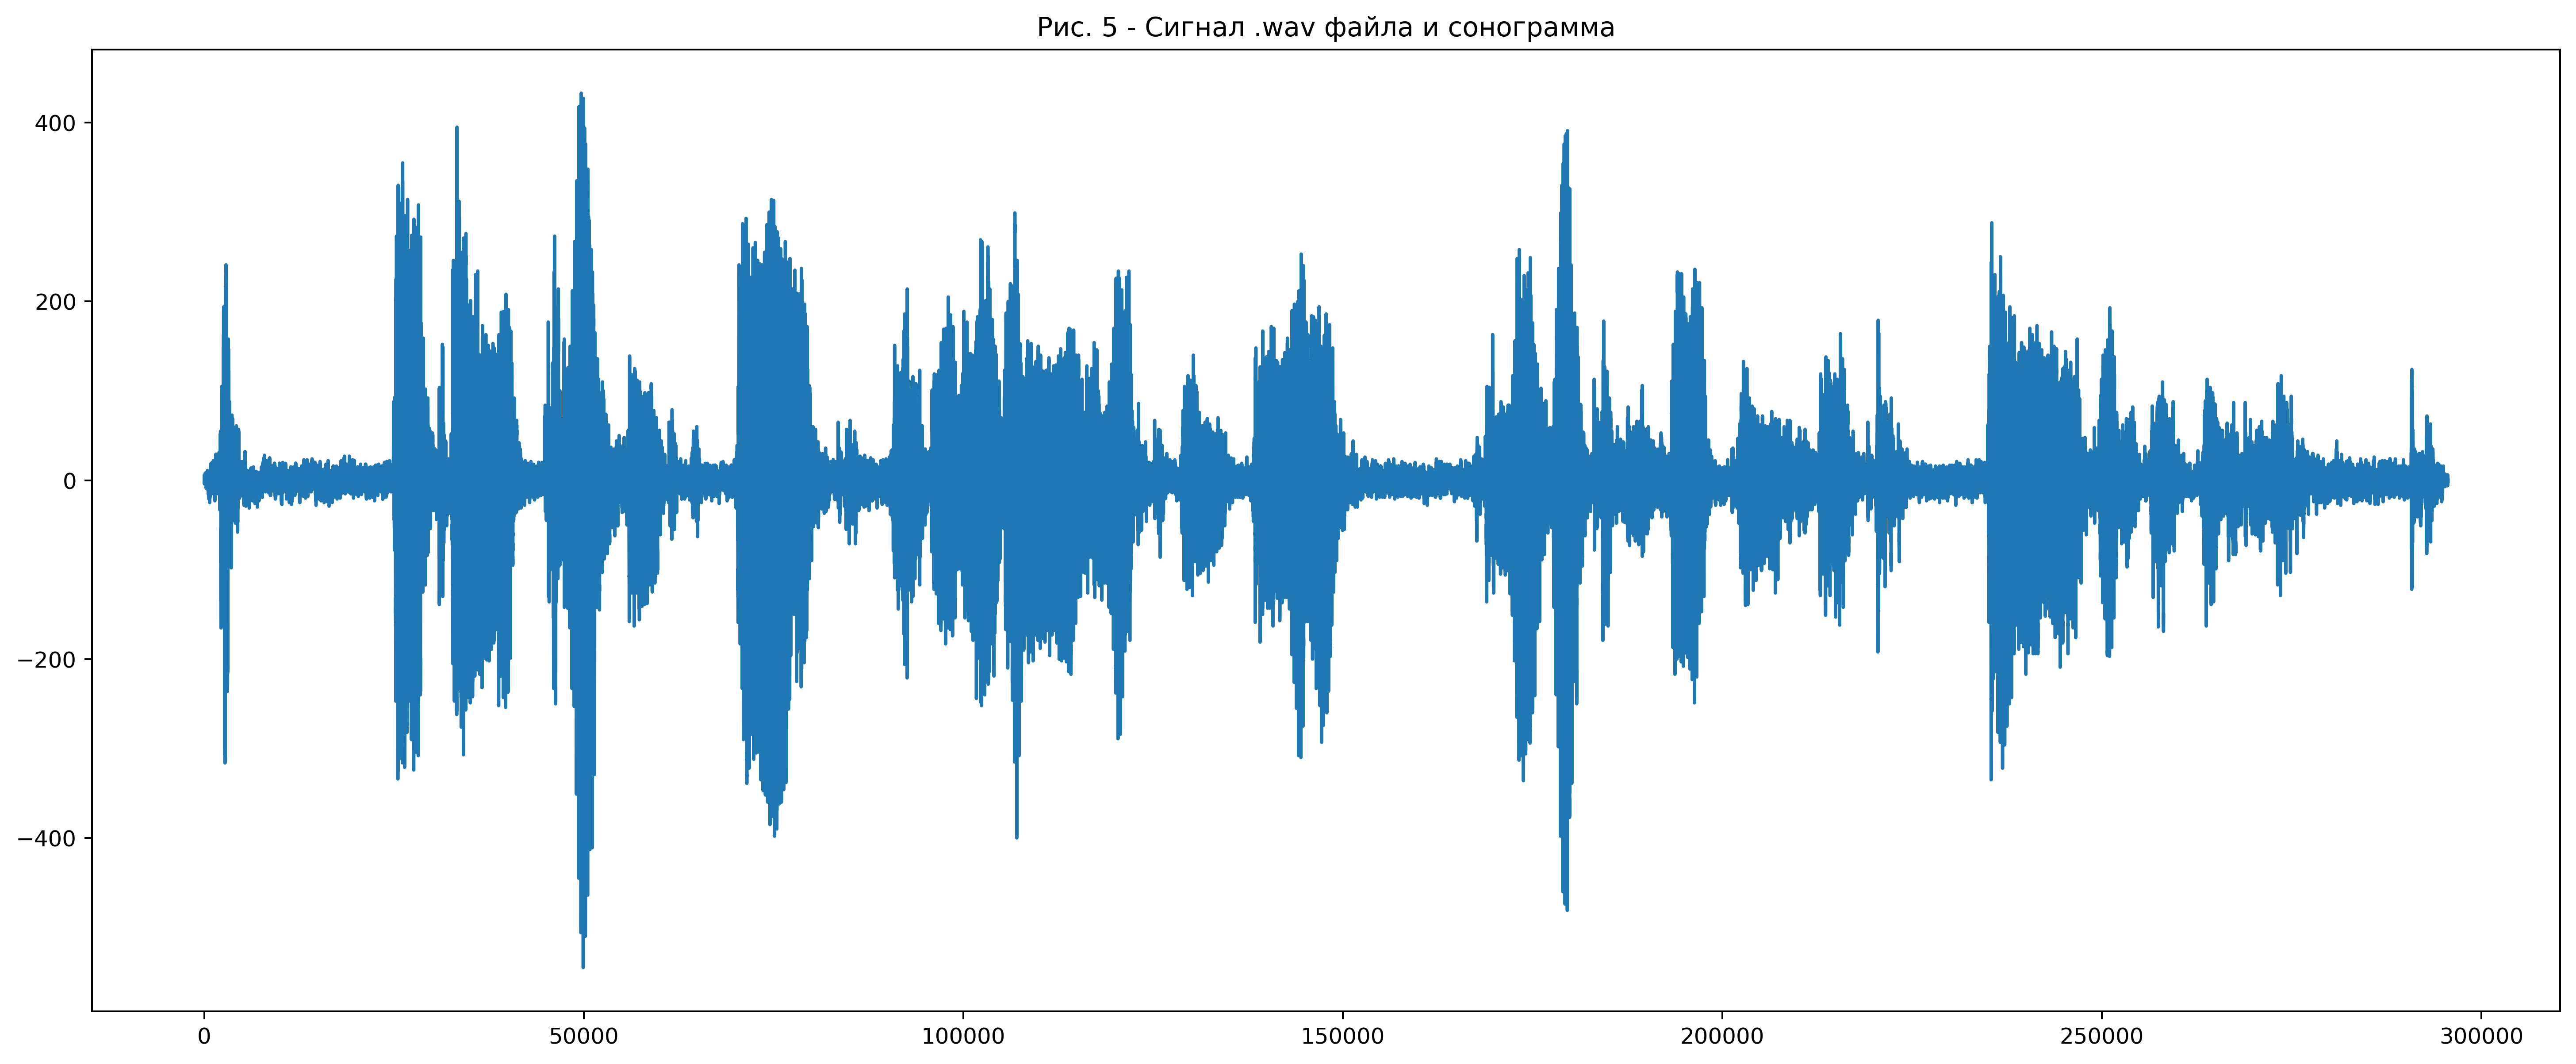

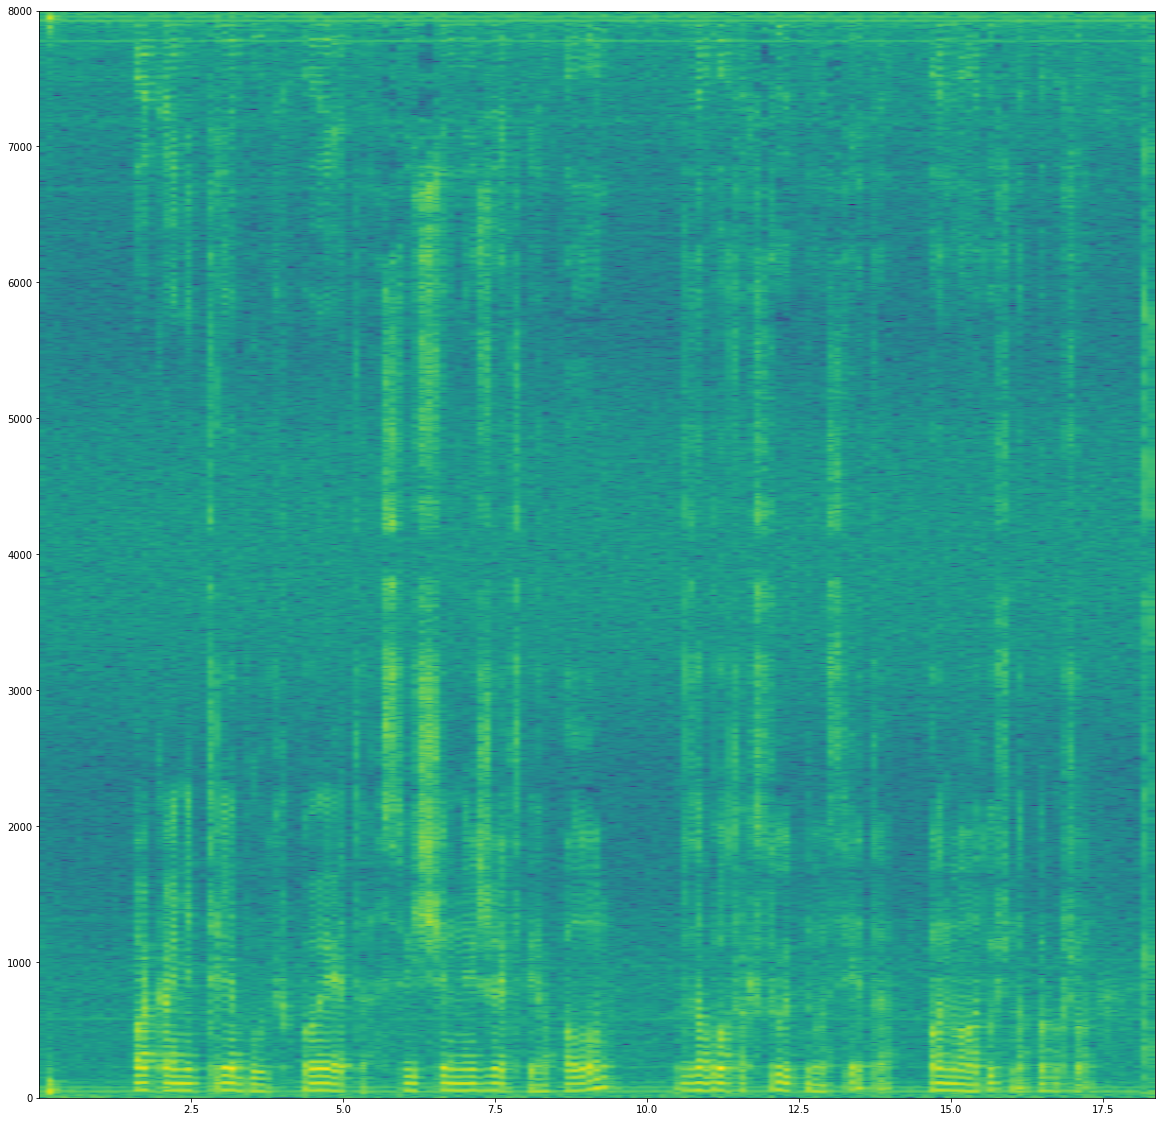

In [8]:
printGraphics(f_i, 'Рис. 5 - Сигнал .wav файла и сонограмма')
plt.figure(figsize=(20, 20))
plt.specgram(f_i,NFFT=N, pad_to=N, Fs=16000)
plt.show()